<p style="text-align: center; font-size: 2.5em; font-weight: bold; height:25px">Приложение</p>

# Решение задачи о течении в трубе с помощью линеаризованного метода Годунова.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Задание основных параметров

In [2]:
Cp = 1005.55  # теплоемкость при постоянном давлении, Дж/(кг·К)
Cv = 718.25  # теплоемкость при постоянном объеме, Дж/(кг·К)
R = 287.3  # газовая постоянная, Дж/(кг·К)
k = 1.4  # показатель адиабаты
L = 1  # длина трубопровода, м
m = 30  # количество ячеек
d = 0.04  # диаметр трубопровода
mas_ring = 0.05  # масса кольца, кг

In [3]:
A = math.pi * pow(d, 2) / 4  # площадь сечения трубы
dx = L / m  # размер одной ячейки, м
print('Площадь: {:.6f}, Длина ячейки: {}'.format(A, dx))

Площадь: 0.001257, Длина ячейки: 0.03333333333333333


## 2. Начальные условия


In [4]:
# В трубе
P0 = 1e5  # Па
T0 = 300  # К
v0 = 0
# справа от трубы
Pb = 1e5
Tb = 300
# слева от трубы
Pa = 1.3e5
Ta = 300

In [5]:
# Параметры кольца
v_ring = 0  # начальная скорость 
x_ring = 0  # начальная координата

### Инициализация массивов параметров в ячейках

In [6]:
p = [P0 for i in range(m)]  # массив давлений
T = [T0 for i in range(m)]  # массив температур
v = [v0 for i in range(m)]  # массив скоростей газа
ro = [p[i] / (R * T[i]) for i in range(m)]  # массив плотностей
a = [math.sqrt(k * R * T[i]) for i in range(m)]  # массив скоростей звука
M = [ro[i] * A * dx for i in range(m)]  # полная масса
K = [M[i] * v[i] for i in range(m)]  # полное количество движения
E = [M[i] * (Cv * T[i] + pow(v[i], 2) / 2) for i in range(m)]  # полная энергия

In [7]:
Co = 0.6  # Число Куранта
dt = Co * dx / a[0]  # шаг по времени
print("Шаг по времени:", dt)

Шаг по времени: 5.757547604347075e-05


### Запись данных в таблицу

In [8]:
data = {'cell': np.arange(m), 'p': p, 'v': v, 'T': T, 'ro': ro, 'time': 0}
df = pd.DataFrame(data)

In [9]:
data_ring = {'v_ring': v_ring, 'x_ring': x_ring, 'time': 0}
df_ring = pd.DataFrame(data_ring, index=[0])

### Инициализация массивов параметров на границах

In [10]:
p_gr = [0 for i in range(m + 1)]
T_gr = [0 for i in range(m + 1)]
v_gr = [0 for i in range(m + 1)]
ro_gr = [0 for i in range(m + 1)]
e_gr = [0 for i in range(m + 1)]
M_gr = [0 for i in range(m + 1)]
K_gr = [0 for i in range(m + 1)]
E_gr = [0 for i in range(m + 1)]
I_gr = [0 for i in range(m + 1)]
L_gr = [0 for i in range(m + 1)]

## * Метод деления отрезка пополам

In [11]:
def popolam(x_left, x_right, side):
    def g(x):
        if side == 'right':
            return v[-1] + (p[-1] - x) / (a[-1] * ro[-1])
        if side == 'left':
            return v[0] - (p[0] - x) / (a[0] * ro[0])

    def f(x):
        if side == 'right':
            return -math.sqrt(2 * k / (k - 1) * R * Tb * (1 - pow(x / Pb, (k - 1) / k)))
        if side == 'left':
            return math.sqrt(2 * k / (k - 1) * R * Ta * (1 - pow(x / Pa, (k - 1) / k)))
        
    x1, x2 = x_left, x_right   
    xc = None
    ACCURACY = 0.01 * (x2 - x1)
    
    if (f(x1) < g(x1) and f(x2) > g(x2)) or (g(x1) < f(x1) and g(x2) > f(x2)):

        while x2 - x1 > ACCURACY:
            xc = (x2 + x1) / 2
            if (f(x1) < g(x1) and f(xc) > g(xc)) or (g(x1) < f(x1) and g(xc) > f(xc)):
                x2 = xc
            elif (f(xc) < g(xc) and f(x2) > g(x2)) or (g(xc) < f(xc) and g(x2) > f(x2)):
                x1 = xc
            else:
                break

    return xc

## 3. Основной цикл МРПР

In [12]:
n = 300  # количество шагов по времени
for t in range(1, n):
    # ГУ слева
    # (втекание) 
    p_gr[0] = popolam(0.5e5, Pa, 'left')
    v_gr[0] = v[0] - (p[0] - p_gr[0]) / (a[0] * ro[0]) 
    T_gr[0] = Ta - pow(v_gr[0], 2) / (2 * Cp)
    ro_gr[0] = p_gr[0] / (R * T_gr[0])
    
    # ГУ справа
    # (истечение)
    p_gr[-1] = Pb
    v_gr[-1] = v[-1] + (p[-1] - p_gr[-1]) / (a[-1] * ro[-1])
    ro_gr[-1] = ro[-1] * (1 + 1 / k * (p_gr[-1] / p[-1] - 1))
    
    # Параметры на внутренних границах
    for i in range(m - 1):
        a_ro = (a[i + 1] * ro[i + 1] + a[i] * ro[i]) / 2
        p_gr[i + 1] = (p[i] + p[i + 1]) / 2 + a_ro * (v[i] - v[i + 1]) / 2
        v_gr[i + 1] = (v[i] + v[i + 1]) / 2 + (p[i] - p[i + 1]) / (2 * a_ro)
        
        if v_gr[i + 1] >= 0:
            ro_gr[i + 1] = ro[i] * (1 + 1 / k * (p_gr[i + 1] / p[i] - 1))
        else:
            ro_gr[i + 1] = ro[i + 1] * (1 + 1 / k * (p_gr[i + 1] / p[i + 1] - 1))
            
    # Объемные параметры на границах ячеек
    for i in range(m + 1):
        e_gr[i] = p_gr[i] / ((k - 1) * ro_gr[i]) + pow(v_gr[i], 2) / 2
        M_gr[i] = ro_gr[i] * v_gr[i] * dt * A
        K_gr[i] = M_gr[i] * v_gr[i]
        E_gr[i] = M_gr[i] * e_gr[i]
        I_gr[i] = p_gr[i] * dt * A
        L_gr[i] = p_gr[i] * v_gr[i] * dt * A
        
    # Расчет параметров кольца
    j = int(round(x_ring / dx))  # номер ячейки где находится кольцо
    if j >= m-1:  # кольцо достигло конца
        a_ring = ((p[-2] - Pb) * A) / mas_ring
        v_ring = v[-1] + a_ring * dt
        x_ring = x_ring + v_ring *dt
    elif j == 0:  # левое гу
        a_ring = ((p_gr[0] - p[1]) * A) / mas_ring
        v_ring = v[0] + a_ring * dt
        x_ring = x_ring + v_ring *dt
    else:  # в трубе
        a_ring = ((p[j] - p[j+1]) * A) / mas_ring
        v_ring = v[j] + a_ring * dt
        x_ring = x_ring + v_ring *dt

    new_ring = {'v_ring': v_ring, 'x_ring': x_ring, 'time': t}
    new_df_ring = pd.DataFrame(new_ring, index=[t])
    df_ring = pd.concat([df_ring, new_df_ring], ignore_index=True)    
    
    # Новые параметры трубопровода
    for i in range(m):
        # Интегральные параметры в ячейке
        M[i] = M[i] + M_gr[i] - M_gr[i + 1]
        K[i] = K[i] + (K_gr[i] + I_gr[i]) - (K_gr[i + 1] + I_gr[i + 1])
        E[i] = E[i] + (E_gr[i] + L_gr[i]) - (E_gr[i + 1] + L_gr[i + 1])
        
        # Пересчет основных газодинамических параметров
        ro[i] = M[i] / (A * dx)
        v[i] = K[i] / M[i]
        T[i] = 1 / Cv * (E[i] / M[i] - pow(v[i], 2) / 2)
        p[i] = (k - 1) * ro[i] * (E[i] / M[i] - pow(v[i], 2) / 2)
        a[i] = math.sqrt(k * R * T[i])
    
    # Добавление в таблицу новых данных       
    new_data = {'cell': np.arange(m), 'p': p, 'v': v, 'T': T, 'ro': ro, 'time': t}
    new_df = pd.DataFrame(new_data)
    df = pd.concat([df, new_df], ignore_index=True)

## 4. Обработка результатов

In [13]:
# создание таблиц соответсвующие шагу по времени
df_5 = df[df['time'] == 10]
df_15 = df[df['time'] == 50]
df_30 = df[df['time'] == 100]
df_45 = df[df['time'] == 250]

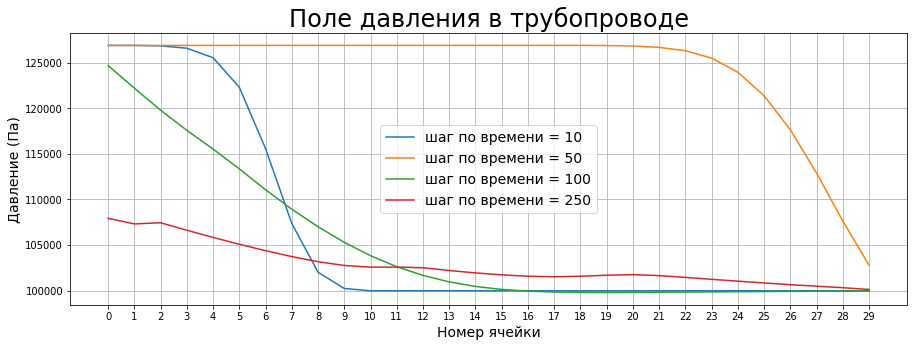

In [14]:
# График давлений
plt.figure(figsize=(15, 5))
plt.plot(df_5['cell'], df_5['p'], label=f"шаг по времени = 10")
plt.plot(df_15['cell'], df_15['p'], label=f"шаг по времени = 50")
plt.plot(df_30['cell'], df_30['p'], label=f"шаг по времени = 100")
plt.plot(df_45['cell'], df_45['p'], label=f"шаг по времени = 250")
plt.xticks(np.arange(m, step=1))
plt.legend(fontsize=14)
plt.grid()
plt.xlabel('Номер ячейки', fontsize=14)                                
plt.ylabel('Давление (Па)', fontsize=14)
plt.title("Поле давления в трубопроводе", fontsize=24)
# plt.savefig('Figures/pressure1.png', bbox_inches='tight')
plt.show()

In [15]:
df_center = df[df['cell'] == m // 2 - 1]  # параметры центральной ячейки

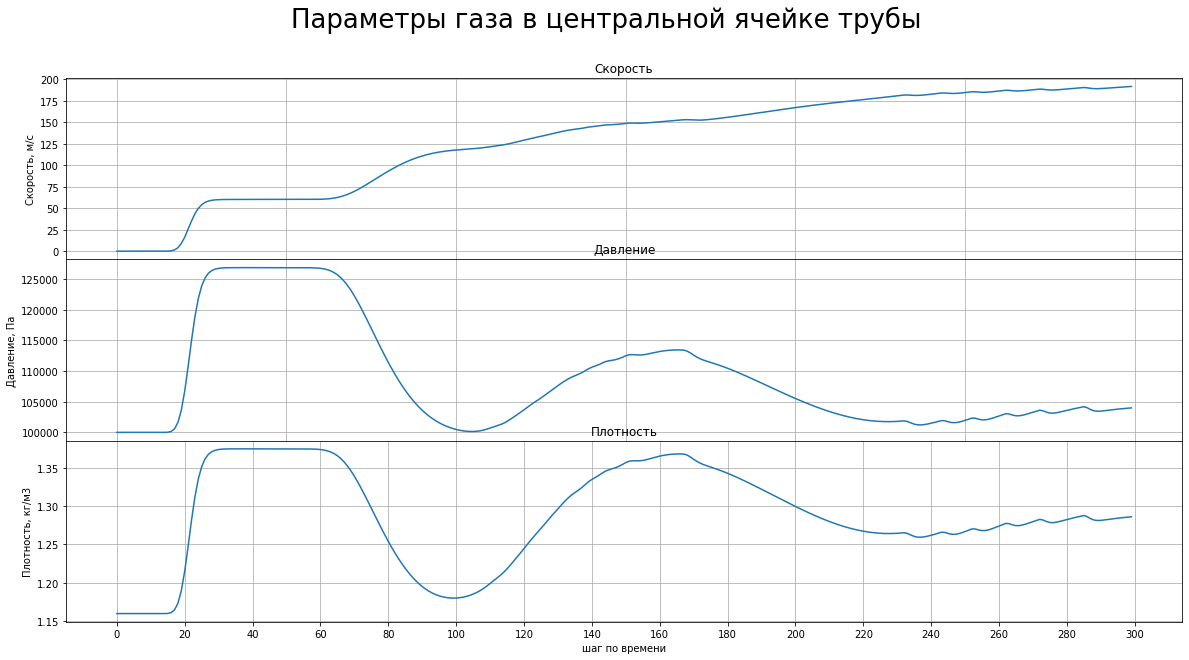

In [16]:
# Параметры в центральной ячейке 
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(3, 1, 1)
ax_2 = fig.add_subplot(3, 1, 2)
ax_3 = fig.add_subplot(3, 1, 3)

ax_1.set(title = 'Скорость', ylabel='Скорость, м/с')
ax_2.set(title = 'Давление', ylabel='Давление, Па')
ax_3.set(title = 'Плотность', xticks=np.arange(n+1, step=20), ylabel='Плотность, кг/м3', xlabel='шаг по времени')

ax_1.plot(df_center['time'], df_center['v'], label="Скорость")
ax_2.plot(df_center['time'], df_center['p'], label="Давление")
ax_3.plot(df_center['time'], df_center['ro'], label="Плотность")
ax_1.grid()
ax_2.grid()
ax_3.grid()

fig.suptitle('Параметры газа в центральной ячейке трубы', fontsize=26)
plt.subplots_adjust(hspace=0)
plt.show()

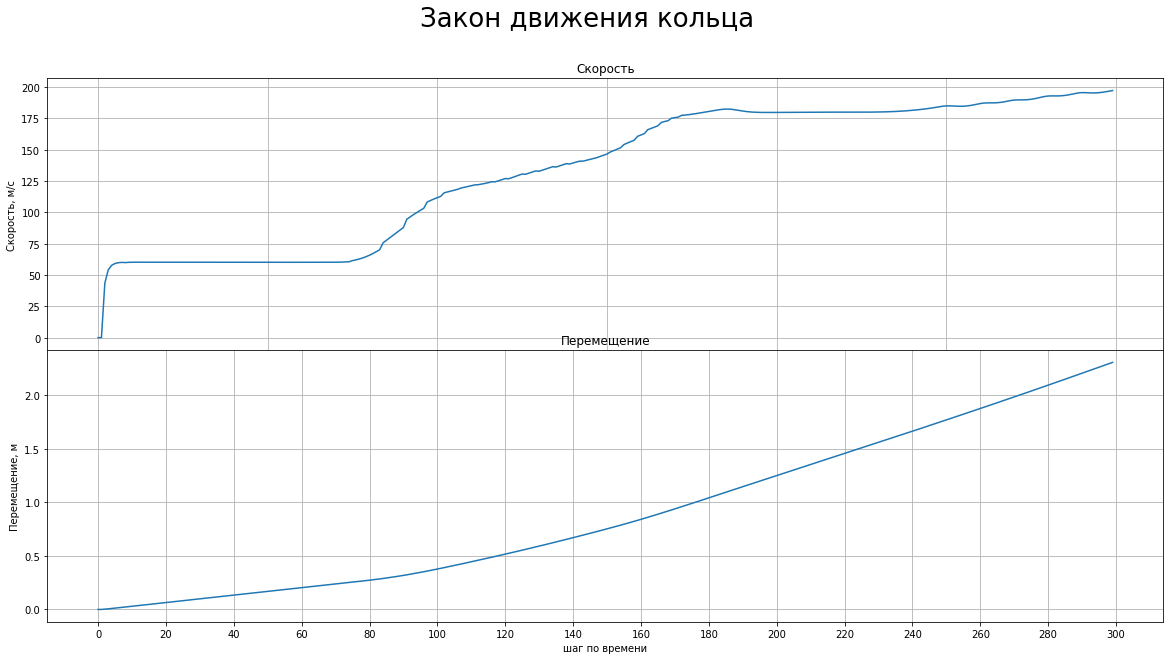

In [17]:
# Закон движения кольца
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 1, 2)

ax_1.set(title = 'Скорость', ylabel='Скорость, м/с')
ax_2.set(title = 'Перемещение', xticks=np.arange(n+1, step=20), ylabel='Перемещение, м', xlabel='шаг по времени')

ax_1.plot(df_ring['time'], df_ring['v_ring'], label="Скорость")
ax_2.plot(df_ring['time'], df_ring['x_ring'], label="Перемещение")
ax_1.grid()
ax_2.grid()

fig.suptitle('Закон движения кольца', fontsize=26)
plt.subplots_adjust(hspace=0)
plt.show()

По графику видно,что перемещение кольца равное длине трубы 1м, достигнется примерно на 175 шаге по времени

In [18]:
t = 175
time_end = t * dt
print(f"Время за которое кольцо дойдет до конца: {round(time_end * 1000)} миллисекунд" )

Время за которое кольцо дойдет до конца: 10 миллисекунд


## 5. Исследование числа Куранта

Маскимальное число Куранта = 0,6 при котором расчет остается устойчивым